In [1]:
import Pkg; Pkg.activate("../"); # Activate the project 
# Import all the necessary libraries
libraries = ["QuTaM", "LinearAlgebra", "Plots", "LaTeXStrings", "Statistics", "OrdinaryDiffEq", "ProgressMeter", 
    "CSV", "DataFrames"]

function ensure_imports(packages::Vector{String})
    for pkg in packages
        try
            @eval using $(Symbol(pkg))
        catch e
            if e isa ArgumentError && occursin(pkg, e.msg)
                println("Installing $pkg...")
                Pkg.add(pkg)
                @eval using $(Symbol(pkg))
            else
                rethrow(e)
            end
        end
    end
end

ensure_imports(libraries)

  Activating project at `~/Documents/Research/MonitoringMetrology/QuTaM.jl`


# Testing Against Gammelmark 2014
They considered the Hamiltonian
$$ H = \Delta|e\rangle\langle e| + \frac{\Omega}{2}(|e\rangle\langle g| + |g\rangle\langle e|)$$
with the jump operator
$$ L = \sqrt{\kappa}|g\rangle\langle e| $$ 

# Observable Convergene

In [2]:
function GetFI(delta::Float64, ntraj::Int64)
    # System and parameters
    H = (delta::Float64, omega::Float64, k::Float64) ->  delta*[[0, 0] [0, 1.0+0im]]  + 0.5*omega*QuTaM.sigma_x
    L = (delta::Float64, omega::Float64, k::Float64) -> sqrt(k)*QuTaM.sigma_m
    He = QuTaM.GetHeffParametrized(H, [L])
    omega = 1.0
    k = 0.5
    sys = System(H(delta, omega, k), # Hamiltonian
    [L(delta, omega, k)]) #Jump Operators
    tf = 300.0
    params = SimulParameters(QuTaM.rf_psi0,
        tf, # Final time. Set very long so that all trajectories jump
        1, # seed
        ntraj, # Number of trajectories
        30_000, # Number of samples in the finegrid
        1.0, # Multiplier to use in the fine grid
        1e-3 # Tolerance for passing Dark state test
    )
    trajectories = run_trajectories(sys, params; progbar=false);
    t_given = [tf];
    ntimes = size(t_given)[1]
    xi_sample = Array{ComplexF64}(undef, sys.NLEVELS, sys.NLEVELS, ntimes, params.ntraj)
    for n in 1:params.ntraj
        xi_sample[:, :, :, n] = MonitoringOperator(t_given, sys, He, [L], trajectories[n],
                                 params.psi0,[delta, omega, k], [delta/100, 0.0, 0.0])
    end 
    fi_sample = Array{Float64}(undef, ntimes, params.ntraj)
    for n in 1:params.ntraj
        for k in 1:ntimes
           fi_sample[k, n] = real(tr(xi_sample[:, :, k, n]))^2 
        end 
    end 
    return fi_sample
end 

GetFI (generic function with 1 method)

In [3]:
delta_gammelmark = 0.2/0.478 * [0.146,0.262,0.383,0.511,0.648,0.806,0.965,1.118,1.287,1.438,1.596,
        1.755,1.888, 2.057, 2.206, 2.381, 2.539, 2.682, 2.865, 3.013, 3.174, 3.334, 3.452]; # The factor is important to match the scale
fi_t_gammelmark = [0.115, 0.221, 0.338, 0.425, 0.507, 0.557, 0.573, 0.566, 0.532, 0.494, 
        0.448, 0.403, 0.363, 0.318, 0.281, 0.241, 0.210, 0.186, 0.156, 0.137, 0.115, 0.101, 0.09348];

ntraj = 2500
fi_samples = Array{Float64}(undef, ntraj, size(delta_gammelmark)[1])
@showprogress for delta_index in 1:size(delta_gammelmark)[1]
    fi_samples[:, delta_index] = GetFI(delta_gammelmark[delta_index], ntraj)
    print("delta_index=$delta_index\n")
end 


delta_index=1
delta_index=2


Progress:  13%|█████▍                                   |  ETA: 1:23:10

delta_index=3


Progress:  17%|███████▏                                 |  ETA: 1:18:53

delta_index=4


Progress:  22%|████████▉                                |  ETA: 1:15:37

delta_index=5


Progress:  26%|██████████▊                              |  ETA: 1:10:48

delta_index=6


Progress:  30%|████████████▌                            |  ETA: 1:05:08

delta_index=7


Progress:  35%|██████████████▎                          |  ETA: 0:59:32

delta_index=8


Progress:  39%|████████████████                         |  ETA: 0:54:06

delta_index=9


Progress:  43%|█████████████████▉                       |  ETA: 0:49:55

delta_index=10


Progress:  48%|███████████████████▋                     |  ETA: 0:44:52

delta_index=11


Progress:  52%|█████████████████████▍                   |  ETA: 0:39:59

delta_index=12


Progress:  57%|███████████████████████▏                 |  ETA: 0:35:17

delta_index=13


Progress:  61%|█████████████████████████                |  ETA: 0:30:50

delta_index=14


Progress:  65%|██████████████████████████▊              |  ETA: 0:26:39

delta_index=15


Progress:  70%|████████████████████████████▌            |  ETA: 0:22:37

delta_index=16


Progress:  74%|██████████████████████████████▎          |  ETA: 0:18:51

delta_index=17


Progress:  78%|████████████████████████████████▏        |  ETA: 0:15:17

delta_index=18


Progress:  83%|█████████████████████████████████▉       |  ETA: 0:11:54

delta_index=19


Progress:  87%|███████████████████████████████████▋     |  ETA: 0:08:40

delta_index=20


Progress:  91%|█████████████████████████████████████▍   |  ETA: 0:05:36

delta_index=21


Progress:  96%|███████████████████████████████████████▎ |  ETA: 0:02:43

delta_index=22


Progress: 100%|█████████████████████████████████████████| Time: 1:01:00


delta_index=23


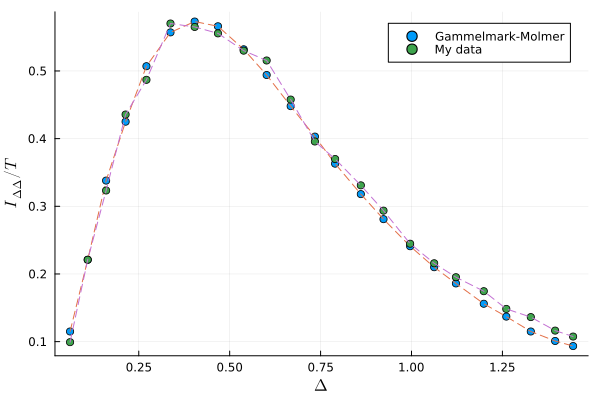

In [4]:
scatter(delta_gammelmark, fi_t_gammelmark, label="Gammelmark-Molmer") # dashlengths=dashlengths)
plot!(delta_gammelmark, fi_t_gammelmark,  label=false, linestyle=:dash, xlabel=L"\Delta", ylabel=L"I_{\Delta\Delta}/T") # dashlengths=dashlengths)
scatter!(delta_gammelmark, dropdims(mean(fi_samples, dims=1), dims=1)/300.0 , label="My data")
plot!(delta_gammelmark, dropdims(mean(fi_samples, dims=1), dims=1)/300.0, label=false, linestyle=:dash)